In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
from pandas.api.types import is_datetime64_any_dtype

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)

# reflect the tables
measurement = Base.classes.measurement
station = Base.classes.station


In [7]:
# View all of the classes that automap found
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
# Save references to tables "measurement" and "stations"
measurement = Base.classes.measurement
stations = Base.classes.station

In [9]:
# Check headers for measurement table
columns1 = inspector.get_columns('measurement')
for c in columns1:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Check headers for station table
columns2 = inspector.get_columns('station')
for c in columns2:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
Last = session.query(measurement.date).order_by(measurement.date.desc()).first()
Last

('2017-08-23',)

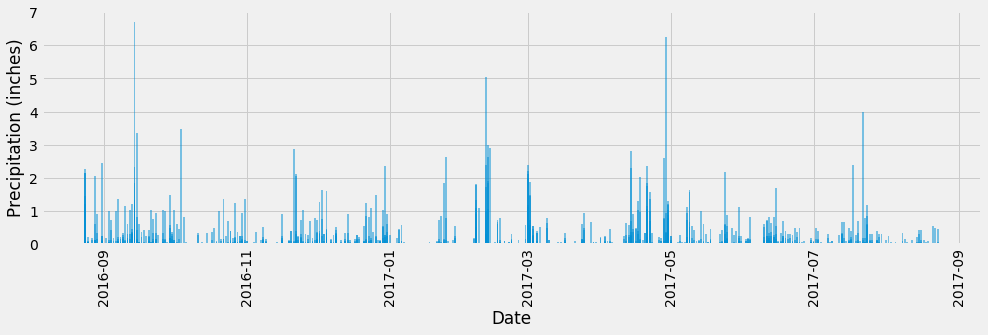

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
First = dt.date(2017,8,23) - dt.timedelta(days=365)
First

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.prcp, measurement.date).filter(measurement.date > First).all()
results

# Save the query results as a Pandas DataFrame. Explicitly set the column names.
# Create two lists to hold the data
Precipitation = [result.prcp for result in results]
Date = [result.date for result in results]

# Create the dataframe to store the precipitation and its corresponding date
df_prcp = pd.DataFrame ({
   "Precipitation" : Precipitation,
    "Date" : Date
})


# Sort the dataframe by date
df_prcp = df_prcp.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data

# Convert the column "Date" to a datetime dtype so when used for the bar chart it will read correctly
df_prcp['Date']= pd.to_datetime(df_prcp['Date'])

# Create the plot with the x-axis being the date and the y axis being the precipitation
plt.rcParams["figure.figsize"] = (15,4)
plt.bar(df_prcp['Date'], df_prcp['Precipitation'], align='center', alpha=0.5)
plt.tight_layout
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")

plt.show()



In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
# Note README file for more information
stats = df_prcp['Precipitation'].describe()
print(stats)


count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
num_stations = session.query(stations).count()
num_stations

9

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# This has to be done using a sub query or a join

# Query for count of individual stations
group_stations = session.execute("SELECT station, COUNT(*) FROM measurement GROUP BY station ORDER BY 2 DESC;")

# For loop to append stations into list. Rememeber .query OR querying from .execute will give you a query not a dataframe or a list
station_count = []
for station in group_stations:
    station_count.append(station)

station_count
#Station USC00519281 has the greatest number of observations at 2772


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# use the tobs column?
one_station = session.execute("SELECT tobs FROM measurement WHERE station = 'USC00519281';")

# Check for null values and append to list so we can do analysis on this stations temperatures
one_station_list = []
for temp in one_station:
    if type(temp.tobs) == float:
        one_station_list.append(temp.tobs)    

#Get stats and append them to a list to save for later
one_station_stats = []
one_station_stats.append(np.min(one_station_list))
one_station_stats.append(np.max(one_station_list))
one_station_stats.append(np.mean(one_station_list))
one_station_stats


[54.0, 85.0, 71.66378066378067]

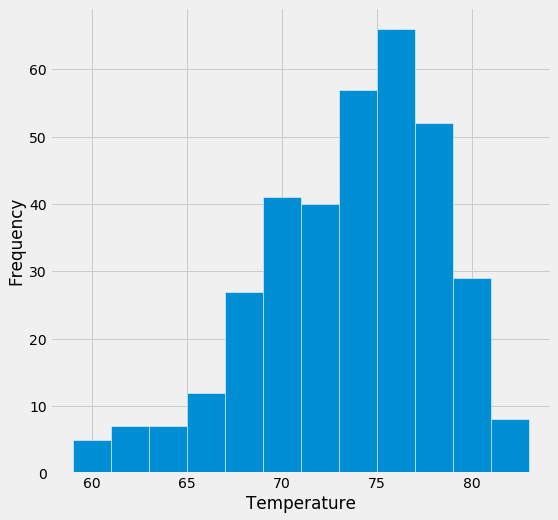

In [19]:
# Using the most active station id (USC00519281)
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
one_station_one_year = session.execute("SELECT tobs FROM measurement WHERE station = 'USC00519281' AND date < '2017-08-23' AND date > '2016-08-23' ;")
one_station_one_year

# save the query to a list so we can create a histogram later
one_station_one_year_list = []
for temp in one_station_one_year:
    if type(temp.tobs) == float:
        one_station_one_year_list.append(temp.tobs) 
        

# Create a dataframe from the single list of temperatures from station (USC00519281)
df_station_one_year = pd.DataFrame ({
    
    "Temperature" : one_station_one_year_list
})

# Plot the temperatures as a histogram to see the frequency of temperatures over the course of the year.
plt.rcParams["figure.figsize"] = (8,8)
plt.hist(one_station_one_year_list, bins=12, linewidth=0.5, edgecolor="white")
plt.xlabel("Temperature")
plt.ylabel("Frequency")

plt.show()



# Close Session

In [20]:
# Close Session
session.close()